# Whitening transform
This notebook explores the effects of the *whitening transform*
(and its subroutine, the *Cholesky decomposition*)
on a few isolated example inputs.

### Cholesky decomposition
Decompose a matrix $M$ into two matrices $W$ of the same shape,
such that
$M = WW^{\top}$.

Note that $M$ must be
1. Symmetric
2. Positive definite
(In the example below, a covariance matrix is used.
These are always symmetric and positive definite.)

Also, $W$ is always lower triangular (i.e. entries
above the main diagonal are always 0).

It is supposedly faster than the Eigenvalue-decomposition.
PyTorch implements both only on the CPU,
so I doubt either is particularly fast to use in Neural Networks.

In [81]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from rolim.tools.stats import sample_covar
from rolim.tools.testing import assert_tensor_eq
from rolim.whitening.whitening import whiten

RNG = np.random.default_rng()




We begin with constructing a random
matrix that is symmetric and positive definite.
Covariance matrices always satisfy those requirements,
so compute the covariance matrix of a random collection of vectors:

In [82]:
shape = (3, 10)
elements = [x for x in range(shape[0]*shape[1])]
elements = RNG.permutation(elements)
sample = torch.tensor(elements, dtype=torch.float).reshape(shape)
m = sample_covar(sample)
m

tensor([[51.5111,  3.2222, -0.2889],
        [ 3.2222, 81.6111, 41.7778],
        [-0.2889, 41.7778, 84.1778]])

In [83]:
w = torch.linalg.cholesky(m)
print(w)
print(w @ w.T)
torch.allclose(m, w@w.T)

tensor([[ 7.1771,  0.0000,  0.0000],
        [ 0.4490,  9.0227,  0.0000],
        [-0.0403,  4.6323,  7.9195]])
tensor([[51.5111,  3.2222, -0.2889],
        [ 3.2222, 81.6111, 41.7778],
        [-0.2889, 41.7778, 84.1778]])


True

Note that $W$ is always lower-triangular.
So we can use torch's dedicated `torch.triangular_solve()`:

In [84]:
output = torch.triangular_solve(torch.eye(w.shape[0]), w)
print(output)
output[0] @ w

torch.return_types.triangular_solve(
solution=tensor([[0.1393, 0.0000, 0.0000],
        [0.0000, 0.1108, 0.0000],
        [0.0000, 0.0000, 0.1263]]),
cloned_coefficient=tensor([[ 7.1771,  0.0000,  0.0000],
        [ 0.4490,  9.0227,  0.0000],
        [-0.0403,  4.6323,  7.9195]]))


tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0498,  1.0000,  0.0000],
        [-0.0051,  0.5849,  1.0000]])

The above does not seem very accurate.
`torch.linalg.inv()` does better:

In [85]:
torch.linalg.inv(w) @ w

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-1.3302e-09, -6.6441e-09,  1.0000e+00]])

## Whitening transform on random 2D vectors
Experiment: sample random 2D vectors from multiple
(arbitrary) distributions, apply the whitening transform, and plot the results.

In [94]:
n1 = RNG.integers(low=10, high=100, dtype=int)
n2 = RNG.integers(low=10, high=100, dtype=int)
n3 = RNG.integers(low=10, high=100, dtype=int)

distr1 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([10, 10], dtype=torch.float), 
    covariance_matrix=torch.eye(2, dtype=torch.float)
)

distr2 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([-1, 0], dtype=torch.float), 
    covariance_matrix= torch.tensor([
        [3, 4], [4, 30]
    ], dtype=torch.float)
)

distr3 = torch.distributions.Poisson(rate=3)

In [95]:
sample1 = distr1.sample((n1,)).reshape((2, -1))
sample2 = distr2.sample((n2,)).reshape((2, -1))
sample3 = distr3.sample((2, n3))

sample = torch.concat((sample1, sample2, sample3), dim=1)
print(f"Generated random sample with shape: {sample.shape}")

whitened_sample = whiten(sample)

Generated random sample with shape: torch.Size([2, 178])


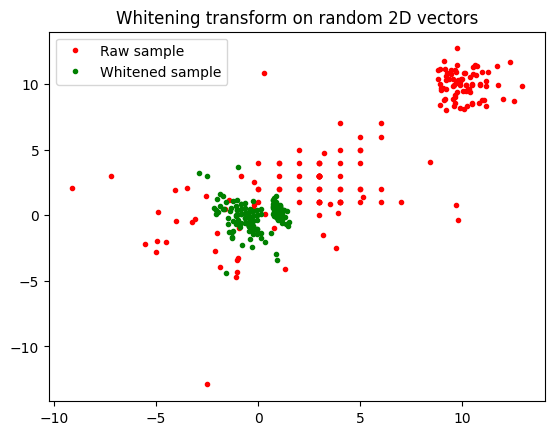

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(sample[0, :], sample[1, :], ".", color="red", label="Raw sample")
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Whitened sample")
ax.legend()
ax.set(**{"title": "Whitening transform on random 2D vectors"});